# Resolución de problemas tipo "stiff"

<ul id="top">
</ul>

In [8]:
using Pkg
#Pkg.add("DifferentialEquations")
#Pkg.add("BenchmarkTools")
Pkg.build("Plots")

  Building GR ───→ `~/.julia/packages/GR/KGODl/deps/build.log`
  Building Plots → `~/.julia/packages/Plots/47Tik/deps/build.log`


In [1]:
using Plots
using DifferentialEquations
using BenchmarkTools
using LinearAlgebra

## 1 -  El problema del péndulo con muelle


Vamos a integrar numéricamente un problema de valor inicial que
corresponde a las ecuaciones del movimiento de un péndulo
formado por dos piezas unidas por un muelle que
se mueve en un plano vertical bajo la influencia de la fuerza de
la gravedad.



<img src="http://www.ehu.eus/ccwmuura/irakaskuntza/sinum/irudiak/pendulo.jpg" alt="pendulo" width="300" >




Este sistema mecánico tiene dos grados de libertad, y podemos
tomar como variables de posición del sistema el ángulo
$a$ y la distancia $L$ entre el punto de giro y el centro de
gravedad de la pieza inferior. Las ecuaciones del movimiento
correspondientes (bajo condiciones ideales de ausencia de
rozamiento) son las siguientes.

\begin{eqnarray*}
\frac{d^2}{dt^2} L &=& L \, \left(\frac{d a}{dt}\right)^2 + g \cos(a) - C_1 (L-L_0), \\
\frac{d^2}{dt^2} a &=& -\frac{g (C_2 + L) \sin(a) + 2 \, L \, \frac{d L}{dt}
\, \frac{d a}{dt}}{C_3 + L^2},
\end{eqnarray*}

donde $g$ es la aceleración de la gravedad, $L_0$ es el valor
de la distancia $L$ correspondiente al estado de reposo del
muelle,

\begin{eqnarray*}
C_1 = \frac{K}{m_2}, \quad C_2 = \frac{r m_1}{m_2}, \quad
C_3 = C_2 r + \frac{I_1+I_2}{m_2}, 
\end{eqnarray*}

$K$ es una constante determinada por la rigidez 
del muelle, $m_1$ y $m_2$ son
respectivamente las masas de la pieza superior e inferior,
$I_1$ e $I_2$ son los momentos de inercia de cada una de las
piezas respecto a su centro de gravedad, y $r$ es la distancia
entre el punto de giro y el centro de gravedad de la pieza
superior.

  Vamos a considerar el caso en que $L_0=1$, 
$g=1$, y las constantes $r$, $m_i,I_i$ (i=1,2) 
son tales que $C_2=1$ y $C_3=1$. Dependiendo de la rigidez del
muelle (dada por la constante $K$), se tendrán distintos
valores de la constante $C_1$. Consideraremos dos casos, que de
menor a mayor rigidez del muelle, serán $C_1 = 100$ y $C_1 = 10000$. 


Queremos
resolver el problema de valor inicial correspondiente a

$$
a(0)=\pi/2, \quad 
%d(0)=1+10^{-6} g \cos a(0), 
L(0)=L_0, 
\quad \frac{d}{dt} a(0)=0, \quad  \frac{d}{dt} L(0)=0,
$$

en el intervalo $t\in[0,40]$. 


A diferencia de las tareas de las semanas anteriores, en lugar de utilizar nuestras propias implementaciones de dichos algoritmos, utilizaremos la implementación disponibles en el paquete de resolución numérica de sistemas de EDOs disponible en Julia (DifferentialEquations.jl):

Haremos uso de dos algoritmos de integración numérica de sistemas de EDOs:
1. Una implementación de paso variable del método de Runge-Kutta de orden 5 de Dormand y Prince, DP5 (La función DOPRI5 implementada en la semana 5 es una versión simplificada de la misma.)
2. El método implícito de RK de orden 5 de Hairer (Hairer5) parecida al método de Radau de orden 5 mostrado en las transparencias del Tema 4. 

Para ello, se ha de llamar a la función solve(), indicándole el método a utilizar (DP5() of Hairer5()), y la tolerancia absoluta (abstol) y tolerancia relativa (reltol) al error local. 
Los algoritmos a utilizar emplean una discretización temporal no uniforme adaptada al problema.

En todas las pruebas que hagamos con los distintos integradores,
variaremos la precisión de la integración variando el valor
de $tol$, y tomando tanto 'abstol' como 'reltol' igual a $tol$.

## 2 - Definición del sistema de EDOs

-  Para empezar, hay que escribir el sistema de arriba como un sistema de EDOs de primer orden de la forma du/dt = f(t,u, p), y posteriormente, **definir en Julia la función fmuelle(u,p,t) tal que f(t,u,p) = fmuelle(u, p, t).**

In [2]:
function fmuelle(u,p,t)
    g=p[1]
    L0=p[2]
    C1=p[3]
    C2=p[4]
    C3=p[5]
    
    L=u[1]
    a=u[2]
    w=u[3]
    v=u[4]
    
    cosa=cos(a)
    sina=sin(a)
    
    return [w, v, L*v*v+g*cosa-C1*(L-L0),-(g*(C2+L)*sina+2*L*w*v)/(C3+L*L)]  
end

fmuelle (generic function with 1 method)

- **Evaluar dicha función para fmuelle(u,p,0.), donde u es el vector de estados correspondiente a los valores $L=1$, $a=2$, $dL/dt=3$, $da/dt=4$, y p es el vector de parámetros constantes correspondiente a $g=5$, $L_0=6$, $C_1=7$,  $C_2=8$,  $C_3=9$.** (Hay que tener en cuenta que las componentes de u y de p deben ser números de coma flotante, y no números enteros.)

In [4]:
u = [1.,2.,3.,4.]
p = [5,6,7,8,9]
fmuelle(u,p,0.)

4-element Array{Float64,1}:
  3.0              
  4.0              
 48.91926581726429 
 -6.491838420715567

> **Comprobación**
> Debería de obtenerse

          4-element Array{Float64,1}:
          3.0              
          4.0              
          48.91926581726429 
          -6.491838420715567

<a href="#top">Back to the top</a>

## 3 - Muelle menos rígido ($C_1 = 100$)

Supongamos que queremos estudiar la evolución de las variables de estado del péndulo con muelle para $C_1=100$, en el intervalo temporal $(0,40)$, y que no nos hace falta mucha precisión en los resultados. Para disminuir el tiempo de CPU, aplicaremos el método DP5 con tol=$10^{-4}$.

- **Para comenzar, antes de aplicar la función _solve_, hay que definir el problema.**


In [5]:
u0=[1., pi/2,0.,0.];
p=[1., 1., 100.,1., 1.]
tspan = (0.,40.)
prob = ODEProblem(fmuelle,u0,tspan,p);

 - **Aplicar DP5 con $tol=10^{-4}$, y representar gráficamente la evolución de las variables de estado con respecto del tiempo.**

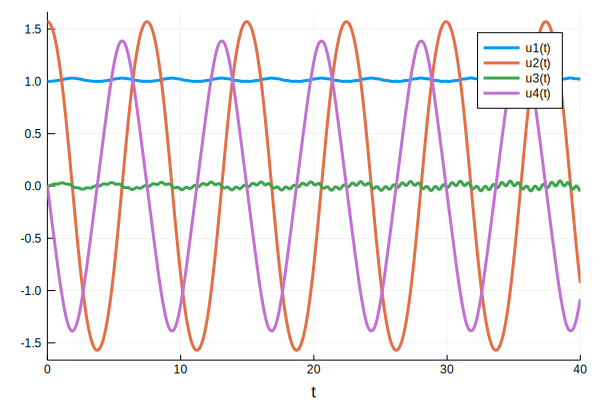

In [9]:
tol=1e-4
sol = solve(prob,DP5(),reltol=tol,abstol=tol)
plot(sol)

- El algoritmo implementado en DP5() calcula las soluciones en una discretización del tiempo no uniforme. **Representar gráficamente la secuencia de longitudes de paso utilizadas a lo largo del intervalo temporal $[0,40]$.**  

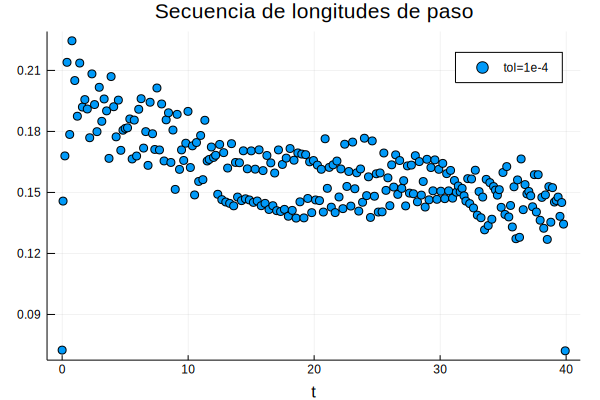

In [10]:
tt = sol.t
tta = tt[1:end-1]
ttb = tt[2:end]
hh = ttb-tta
plot(tta,hh,title="Secuencia de longitudes de paso", xlabel="t", label="tol=1e-4", 
     seriestype=:scatter)

- Para comprobar la precisión de los resultados, **volver a aplicar DP5() al problema, pero esta vez con tol=$10^{-8}$.** Ahora, los resultados los calcula para otra discretización temporal no uniforme (más fina que la anterior, es decir, con más valores de los tiempos). **Para comprobarlo, comparar el número de instantes del tiempo considerados en los resultados obtenidos respectivamente con tol=$10^{-4}$ y con tol=$10^{-8}$.**

In [11]:
tol2=1e-8
sol2 = solve(prob,DP5(),reltol=tol2,abstol=tol2);
(length(sol.t), length(sol2.t))

(252, 1112)

>**Comprobación**
>  
> En el caso tol=1e-4, resulta una discretización temporal con 252 valores del tiempo, 
> y en el caso tol=1e-8, en cambio, 1112. 

 - Consideraremos los resultados recién obtenidos como exactos (pues se supone que son mucho más precisos que los obtenidos con tol=$10^{-4}$). Hay que tener en cuenta que, aunque en cada uno de los dos casos (_sol_ para la solución numérica menos precisa, y _sol2_ para la solución "exacta") calcula los resultados para discretizaciones temporales distintas, se pueden calcular los valores "exactos" de las variables de estado en cualquier valor de $t$ dentro del intervalo temporal $[0,40]$. Para ello, basta con poner sol2(t) (el algoritmo aplica técnicas de interpolación para calcular una aproximación del vector de estados en t).
 **Como comprobación adicional, calcular los valores "exactos" de las variables de estado en $t=14.5$.**  

In [12]:
sol2(14.5)

4-element Array{Float64,1}:
  1.0030050443733272  
  1.4642087270483626  
 -0.016590545719411362
  0.4602876475898731  

>**Comprobación**
>  
> Se deberían de obtener los siguientes valores de las variables de estado
>

           1.0030050443733272  
           1.4642087270483626  
          -0.016590545719411362
           0.4602876475898731                                 

 
 - **Definir una función errfun(t) que calcule la norma de los errores cometidos en el caso de tol=$10^{-4}$ en el tiempo t. Representar gráficamente la evolución de dicha norma de los errores en los tiempos de la discretización temporal de los resultados obtenidos para tol=$10^{-4}$.**

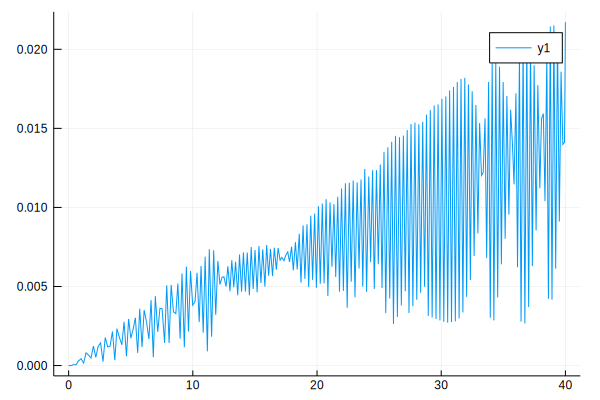

In [13]:
errfun(t) = norm(sol(t).-sol2(t))
errores = errfun.(tt)
plot(tt,errores)

- **Utilizar @btime para medir y comparar los tiempos de ejecución para los resultados obtenidos con tol=$10^{-4}$ y con tol=$10^{-8}$ respectivamente.**

In [14]:
@btime solve(prob,DP5(),reltol=tol,abstol=tol);

  1.883 ms (33895 allocations: 2.92 MiB)


In [15]:
@btime solve(prob,DP5(),reltol=tol2,abstol=tol2);

  7.303 ms (130905 allocations: 11.30 MiB)


- **Comentar los resultados de tiempos de ejecución obtenidos.**
> 
> Se comprueba que, como era de esperar, se necesita más tiempo de cómputo (más del cuádruple) para obtener los resultados más precisos.

## 4 - Muelle más rígido ($C_1 = 10000$)

### 4.1 - Método DP5

Ahora queremos volver a repetir los cálculos del punto anterior, pero para el caso en el que muelle sea más rígido, en concreto, con $C_1 = 10000$.


- **Para comenzar, antes de aplicar la función _solve_, hay que redefinir el problema.**


In [16]:
pS=[1., 1., 10000.,1., 1.]
probS = ODEProblem(fmuelle,u0,tspan,pS);

 - **Aplicar DP5 con $tol=10^{-4}$, y representar gráficamente la evolución de las variables de estado con respecto del tiempo, pero esta vez, cada variable de estado en una figura diferente** (debido a que tienen escalas de valores bastante diferentes).

In [17]:
tol=1e-4
solS = solve(probS,DP5(),reltol=tol,abstol=tol)

pl1 = plot(solS, vars=(0,1), xlabel = "t", label = "L")
pl2 = plot(solS, vars=(0,2), label = "a")
pl3 = plot(solS, vars=(0,3), label = "dL/dt")
pl4 = plot(solS, vars=(0,4), label = "da/dt")

plot(pl1,pl2,pl3,pl4,layout=(2,2))

- Para comprobar la precisión de los resultados, **volver a aplicar DP5() al problema, pero esta vez con tol=$10^{-8}$. Antes que nada, comparar el número de instantes del tiempo considerados en los resultados obtenidos respectivamente con tol=$10^{-4}$ y con tol=$10^{-8}$.**

In [18]:
tol2=1e-8
sol2S = solve(probS,DP5(),reltol=tol2,abstol=tol2);
(length(solS.t), length(sol2S.t))

(3258, 3415)

- **Comentar el resultado**
>  
> El tiempo de ejecución en ambos casos es bastante parecido, a pesar que en el segundo caso la tolerancia sea muchísimo más estricta. Esto contrasta con lo comprobado en el caso $C_1=100$. 

 
 - ** Representar gráficamente la evolución de la norma de los errores de los resultados obtenidos para tol=$10^{-4}$.**

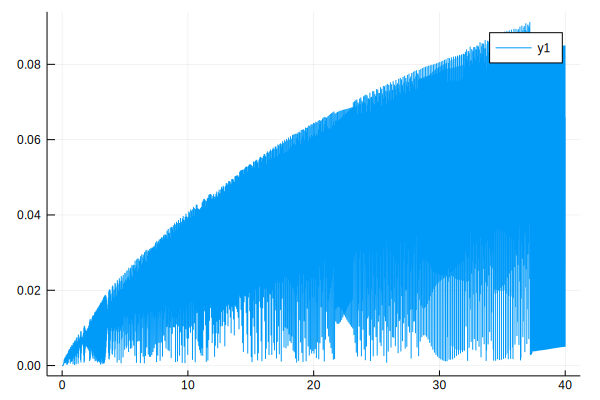

In [19]:
errfunS(t) = norm(solS(t).-sol2S(t))
ttS = solS.t
erroresS = errfunS.(ttS)
plot(ttS,erroresS)

- **Utilizar @btime para medir y comparar los tiempos de ejecución para los resultados obtenidos con tol=$10^{-4}$ y con tol=$10^{-8}$ respectivamente.**

In [20]:
@btime solve(probS,DP5(),reltol=tol,abstol=tol);

  34.174 ms (454687 allocations: 39.25 MiB)


In [21]:
@btime solve(probS,DP5(),reltol=tol2,abstol=tol2);

  34.962 ms (461804 allocations: 39.87 MiB)


- **Comentar los resultados de tiempos de ejecución obtenidos.**
> 
> Los tiempos obtenidos concuerdan con el parecido número de pasos dado en cada uno de los dos casos. Esto no era en principio de esperar, pues se supone que en el segunda caso los resultados son mucho más precisos. Esto es debido a que el problema es de tipo "stiff", debido a lo cual los métodos explícitos como DP5 no son apropiedos para precisiones bajas, pues en ese casos no funcionan coréctamente debido a problemas de inestabilidad.

### 4.2 - Método RK implícito de Hairer de orden 4 (Hairer4)

- **Aplicar Hairer4() con $tol=10^{-4}$, y representar gráficamente la evolución de las variables de estado con respecto del tiempo,  cada variable de estado en una figura diferente**.

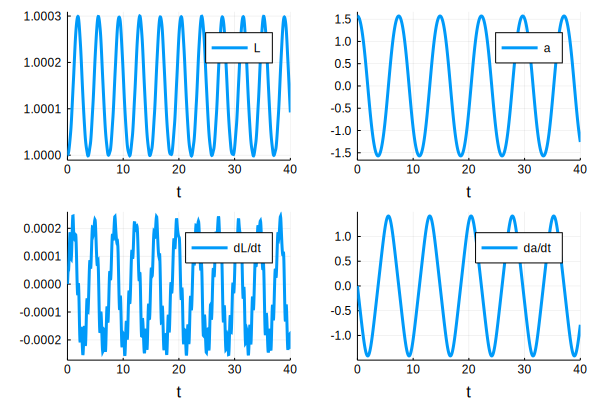

In [22]:
solS = solve(probS,Hairer4(),reltol=tol,abstol=tol)

pl1 = plot(solS, vars=(0,1), xlabel = "t", label = "L")
pl2 = plot(solS, vars=(0,2), label = "a")
pl3 = plot(solS, vars=(0,3), label = "dL/dt")
pl4 = plot(solS, vars=(0,4), label = "da/dt")

plot(pl1,pl2,pl3,pl4,layout=(2,2))

- Para comprobar la precisión de los resultados, **volver a aplicar Hairer4() al problema, pero esta vez con tol=$10^{-8}$. Antes que nada, comparar el número de instantes del tiempo considerados en los resultados obtenidos respectivamente con tol=$10^{-4}$ y con tol=$10^{-8}$.**

In [23]:
tol2=1e-8
sol2S = solve(probS,Hairer4(),reltol=tol2,abstol=tol2);
(length(solS.t), length(sol2S.t))

(94, 4536)

- **Comentar el resultado, comparandolo con lo ocurrido en el caso de DP5**
>  
> Aquí ya se obtienen resultados consistentes. El caso es que Hairer5 es la implementación de un método de Runge-Kutta explícito apropiado para problemas de tipo "stiff". 

 
 - ** Representar gráficamente la evolución de la norma de los errores de los resultados obtenidos para tol=$10^{-4}$.**

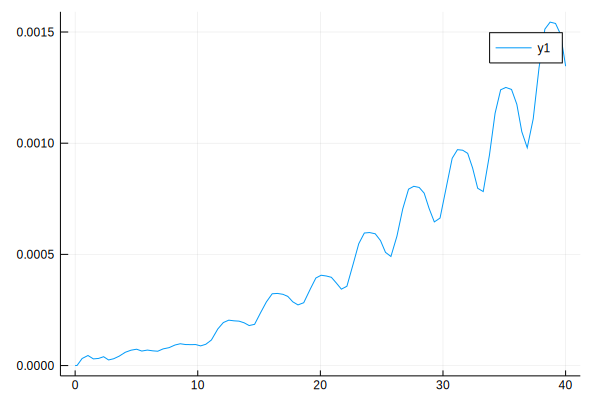

In [24]:
errfunS(t) = norm(solS(t).-sol2S(t))
ttS = solS.t
erroresS = errfunS.(ttS)
plot(ttS,erroresS)

- **Utilizar @btime para medir y comparar los tiempos de ejecución para los resultados obtenidos con tol=$10^{-4}$ y con tol=$10^{-8}$ respectivamente.**

In [25]:
@btime solve(probS,Hairer4(),reltol=tol,abstol=tol);

  3.782 ms (26575 allocations: 2.09 MiB)


In [26]:
@btime solve(probS,Hairer4(),reltol=tol2,abstol=tol2);

  201.904 ms (1203117 allocations: 97.51 MiB)


- **Comentar los resultados de tiempos de ejecución obtenidos, comparandolos con los obtenidos con DP5.**
> 
> Para la tolerancia 1e-4, Hairer4 da resultados claramente más precisos en la mitad de tiempo (pues requiere muchos menos pasos). En cambio, para tol=1e-8, Hairer5 es mucho más costoso, pues requiere un número de pasos parecidos (de hecho algo más) que DP, y al mismo tiempo, cada paso de Hairer5 es mucho más costoso (pues se trata de un método implícito).

**¿Que podemos decir en cuanto a la eficiencia de los dos métodos, en este ejemplo con $C_1=10000$?**

> Por lo comentado en el anterior punto, para tol=1e-4, el método implícito Hairer4 ha resultado más eficiente. En cambio, para tol=1-8, el método explícito DP5 resulta ser claramente más eficiente en este ejemplo.


### Valoración

_Incluir aquí los comentarios de valoración de la tarea a entregar (dificultad, interés, etc, incluidas, si se quiere, sugerencias de mejora del ejercicio), así como una estimación del tiempo dedicado al trabajo de la semana (desglosado en el tiempo de estudio de material teórico, tiempo de dedicación a la participación activa o pasiva en los foros, tiempo de implementación y experimentación con los problemas prácticos planteados, y tiempo de preparación del documento jupyter final)._